#### Deep Learning

# Basic Classification
#### Francisco Maiocchi

***
### Introducción

Este ejemplo utiliza redes neuronales para clasificar reseñas de películas como positivas o negativas. Es un ejemplo de clasificación binaria. Se utiliza un dataset de IMDB que contiene 50000 reseñas de Internet Movie Databese. Esta dividido en 25000 reseñas para entrenamiento y 25000 para test. Ambos sets estan balanceados, esto quiere decir que contienen igual cantidad de reseñas positivas que negativas. Utiliza KERAS que es la API de alto nivel de TensorFlow. Este ejemplo está en web oficial de TensorFlow en https://www.tensorflow.org/tutorials/keras/basic_text_classification?hl=es  

***
### Imports

In [14]:
# Importo TensorFlow como tf
import tensorflow as tf
# Importo keras
from tensorflow import keras

# Librerias auxiliares
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.12.0


***
### Descargo el dataset de IMDB desde TensorFlow
Este dataset ya ha sido preprocesado de manera que cada review (secuencia de palabras) fue convertida en secuencia de números enteros, donde cada uno representa una palabra especifica en el diccionario.

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

17465344/17464789 [==============================] - 7s 0us/step


El argumento num_words=10000 se queda solo con las 10000 palabras más frecuentes para que el tamaño de los datos sea manejable.

***
### Exploremos un poco el dataset
Cada ejemplo es un array de numeros enteros que representan palabras de una reseña. Cada label es un entero que con valor 0 (negativo) o 1 (positivo).

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


Miremos como se ve la primer reseña:

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


#### Convertir los números a palabras
Vamos a crear una función encargada de esta tarea.

In [5]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

1646592/1641221 [==============================] - 0s 0us/step


Ahora podemos usar esta función para mostrar el texto de la reseña

In [7]:
print(decode_review(train_data[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

A su vez, podemos darnos cuenta que las distintas reseñas pueden tener largos distintos, lo cual es un problema a la hora de ingresar a la red. Esto lo analizaremos en la siguiente sección

***
### Preparación de los datos
Las reseñas (arrays de números) deben convertirse en tensores antes de ingresar a la red neuronal. Esta conversión puede realizarce de distintas maneras:  
+ Convertir el array en vectores de 0s y 1s indicando la ocurrencia de la palabra. Por ejemplo la secuencia [3, 5] se convierte en un de tamaño 10000 con todos 0s excepto los indices 3 y 5 que valen 1. Luego, la primer capa de la red (Dense layer) que puede manejar punto flotante. Esta alternativa es exigente en memoria ya que requiere una matriz de num_words*num_reviews.
+ Se puede igualar el tamaño de los arrays haciendo padding y luego crear un tensor de enteros de tamaño max_length*num_reviews. Se puede utilizar un capa embedding layer capaz de manejar estas dimensiones como primer capa.  

Vamos a utilizar la segunda alternativa. Ya existe una función para realizar el padding llamada pad_sequences.

In [8]:
# Padding de train_data
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

# Padding de test_data
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

Ahora ya tenemos todo el set con el mismo tamaño y podemos arrancar a contruir el modelo.

***
### Armado del modelo
La red neural se construye apilando capas. Esto requiere tomar algunas decisiones importantes respecto a la arquitectura: 

+ Cuantas capas debemos utilizar?
+ Cuantas neuronas en cada capa oculta?

Por los datos de entrada y las clasificaciones posibles vamos a proponer el siguiente modelo:

In [9]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


+ La primer capa es de tipo Embedding layer. Recibe un vocubalario codificado con enteros y busca el vector embedding de cada indice de palabra. Estos vectores son aprendidos a medida que el modelo aprende. Se añade una dimensión al array de salida, siendo (batch, sequence, embedding). https://es.wikipedia.org/wiki/Word_embedding
+ Luego, una capa GlobalAveragePooling1D devuelve un vector de tamaño fijo por cada ejemplo. Esto lo hace promediando la secuencia. Esto permite al modelo manejar datos de tamaños distintos de la forma más simple posible.
+ Una capa de 16 neuronas fully-connected.
+ La última capa está densamente conectada y esta compuesta por una única neurona. Usa la función activación sigmoid lo que devuelve un valor entre 0 o 1 que representa la probabilidad.  

#### Neuronas ocultas
El modelo anterior tiene dos capas intermedias u ocultas entre la capa de entrada y la de salida. El número de salidas (unidades, nodos o neuronas) es la dimensión espacial que puede representar la capa. En otras palabras, la libertad que tiene la red para aprender cosas internamente.  

Si un modelo tiene muchas neuronas ocultas o capas, entonces la red puede aprender cosas más complejas. Sin embargo, la red se vuelve computacionalmente más costosa y puede llegar a aprender patrones no desiados (overfitting).  

#### Loss function y optimizer
Todos los modelos necesitan una loss function y un optimizer. Como esta es una clasificación binaria y la salida del modelo es una probabilidad, vamos a usar una loss function del tipo binary_crossentropy.  

Esta no es la única alternativa, se puede utilizar otras como por ejemplo mean_squared_error. Pero generalmente, binary_crossentropy es mejor para trabajar con probabilidades. Mide la distancia entre las distribuciones probabilidad.


In [10]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

***
### Creación de un set de validación
Cuando entrenamos, queremos corroborar la efectividad del modelo en datos que no haya analizado antes. Por esto creamos un set de validación separando 10000 ejemplos del set original de entrenamiento. Por que lo hacemos desde el set de entrenamiento? El objetivo es desarrollar y ajustar el modelo usando solo datos de entrenamiento, luego usamos los datos de test una sola vez para evaluar la precisión.

In [11]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

***
### Entrenamiento del modelo
Vamos a entrenar el modelo durante 40 épocas en mini-batches de 512 ejemplos. Esto significa 40 iteraciones de todos los ejemplos de los tensores x_train e y_train. Mientras se entrena, se puede monitorear la métricas del modelo en los 10000 ejemplos del set de validación. 

In [12]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 1s 78us/step - loss: 0.6922 - acc: 0.5216 - val_loss: 0.6906 - val_acc: 0.6281
Epoch 2/40
15000/15000 [==============================] - 1s 56us/step - loss: 0.6875 - acc: 0.6833 - val_loss: 0.6844 - val_acc: 0.7247
Epoch 3/40
15000/15000 [==============================] - 1s 57us/step - loss: 0.6779 - acc: 0.7433 - val_loss: 0.6722 - val_acc: 0.7263
Epoch 4/40
15000/15000 [==============================] - 1s 57us/step - loss: 0.6598 - acc: 0.7652 - val_loss: 0.6518 - val_acc: 0.7450
Epoch 5/40
15000/15000 [==============================] - 1s 60us/step - loss: 0.6324 - acc: 0.7845 - val_loss: 0.6222 - val_acc: 0.7783
Epoch 6/40
15000/15000 [==============================] - 1s 55us/step - loss: 0.5968 - acc: 0.8054 - val_loss: 0.5870 - val_acc: 0.7989
Epoch 7/40
15000/15000 [==============================] - 1s 55us/step - loss: 0.5554 - acc: 0.8240 - val_loss: 0.5483 - val_acc

***
### Evaluación del modelo
Ahora veamos como funciona con el set de test.

In [13]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 22us/step
[0.31590844766139986, 0.87396]


Esta enfoque simple logra un 87% de precisión. Complejizando un poco el modelo se puede llegar a un 95%.

***
### Creación de gráfico de precisión y error en el tiempo
model.fit() devuelve un objeto History un diccionario con toda la información de todo lo que sucedió en el entrenamiento. 


In [15]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Hay cuatro entradas. Una por cada métrica en entrenamiento y en validación. Podemos utilizar esto para graficar la comparación entre entrenamiento y vaidación de las métricas.

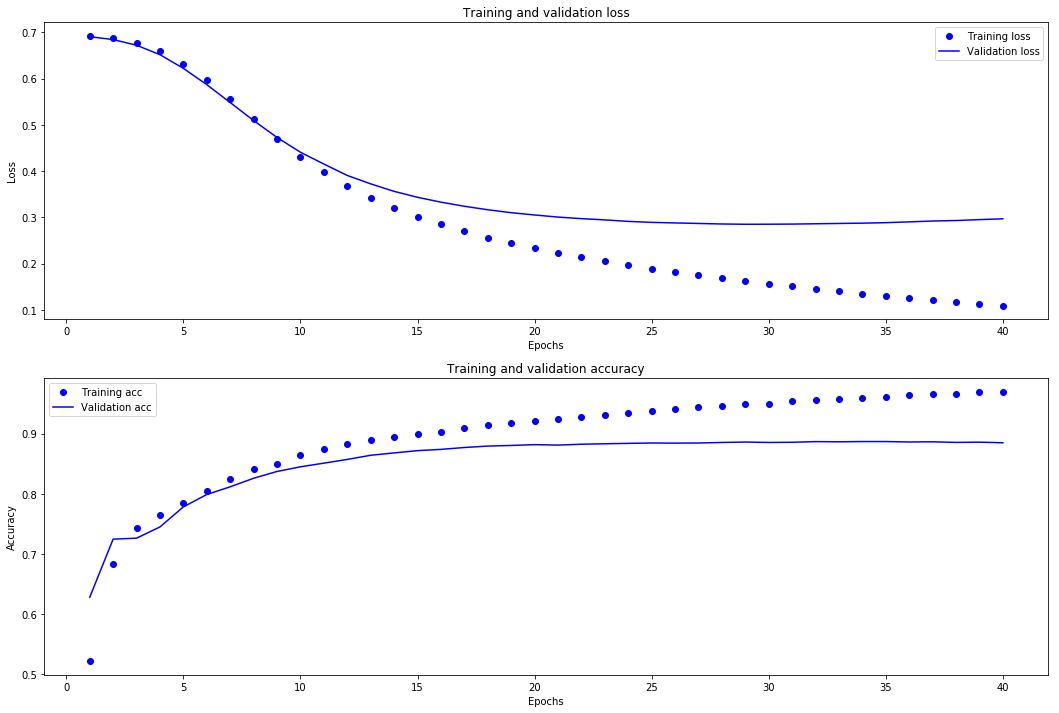

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(18,12))
plt.subplot(2,1,1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2)
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Se puede ver como disminuye el error y mejora la precisión del entrenamiento a lo largo de todas las épocas. Esto es lógico si se utiliza un gradiente descendente de optimización.  

Este no es el caso para el set de validación ya que se parece alcanzar un pico alrededor de las 20 épocas. Esto es un ejemplo de overfitting. El modelo funciona mejor con los datos del entrenamiento que con los datos de validación.  

Para este caso particular se puede arreglar cortando en 20 épocas el entrenamiento. Más adelante veremos como hacer esto de forma automática.

